# Installs

In [ ]:
! pip install -q ucimlrepo ipywidgets

# Imports

In [1]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

import pandas as pd
import numpy as np

# EDA

In [7]:
df = fetch_ucirepo(id=183).data.original

In [8]:
df.drop(columns=['state', 'county', 'community', 'communityname', 'fold'], inplace=True)
df.replace('?', np.nan, inplace=True)
# Convert OtherPerCap column to numeric (it is string for some reason)
df['OtherPerCap'] = pd.to_numeric(df['OtherPerCap'], errors='coerce')
print(f"Dataset shape: {df.shape}")

Dataset shape: (1994, 123)


In [9]:
total_missing_values = df.isnull().sum().sort_values(ascending=False)
percent_missing_values = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing_values, percent_missing_values], axis=1, keys=['Total', 'Percent'])
missing_data.head(24)

,Total,Percent
PolicAveOTWorked,1675,0.840020
LemasTotalReq,1675,0.840020
LemasSwFTFieldPerPop,1675,0.840020
PctPolicWhite,1675,0.840020
RacialMatchCommPol,1675,0.840020
LemasSwFTPerPop,1675,0.840020
LemasSwFTFieldOps,1675,0.840020
PolicReqPerOffic,1675,0.840020
LemasTotReqPerPop,1675,0.840020
LemasSwornFT,1675,0.840020


Remove the fields that have high number of missing values

In [10]:
df.drop((missing_data[missing_data['Total'] > 1600]).index, axis=1, inplace=True)
df.shape

(1994, 101)

Fill the NaN value of racePctWhite with the Median value

In [11]:
df['OtherPerCap'].fillna(df['OtherPerCap'].median(), inplace=True)

C:\Users\shamb\AppData\Local\Temp\ipykernel_28776\677835685.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['OtherPerCap'].fillna(df['OtherPerCap'].median(), inplace=True)


Segregate data

In [12]:
X = df.drop(columns=['ViolentCrimesPerPop'])
y = df['ViolentCrimesPerPop']

# Test-Train split

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_test), len(X_val), len(X)

(1395, 300, 299, 1994)

# Neural Network Scratch Implementation

In [14]:
class Linear:
  """
  Linear Layer
  """

  def __init__(self, input_size: int, output_size: int) -> None:
    """
    Initialize the linear layer.

    Args:
      input_size (int): The size of the input.
      output_size (int): The size of the output.
    """

    # He initialization of the weight matrix
    self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
    self.bias = np.zeros((1, output_size))
    self.outputs = np.zeros((1, output_size))

  def __call__(self, input: np.ndarray) -> None:
    """
    Forward pass of the linear layer.
    """

    self.outputs = np.dot(input, self.weights) + self.bias
    return self.outputs
  
class ReLU:
  """
  ReLU Activation Function
  """

  def __init__(self) -> None:
    """
    Initialize the ReLU activation function.
    """
    self.outputs = None

  def __call__(self, input: np.ndarray) -> None:
    """
    Forward pass of the ReLU activation function.
    """

    self.outputs = np.maximum(0, input)
    return self.outputs
  
class deReLU:
  """
  Derivative of ReLU Activation Function
  """

  def __init__(self) -> None:
    """
    Initialize the derivative of ReLU activation function.
    """
    self.outputs = None

  def __call__(self, input: np.ndarray) -> None:
    """
    Forward pass of the derivative of ReLU activation function.
    """

    self.outputs = np.where(input > 0, 1, 0)
    return self.outputs
  
class HuberLoss:
  """
  Huber Loss Function
  """

  def __init__(self, delta: float = 1.0) -> None:
    """
    Initialize the Huber loss function.

    Args:
      delta (float): The threshold parameter for Huber loss.
    """

    self.delta = delta

  def __call__(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Compute the Huber loss.

    Args:
      y_true: True labels.
      y_pred: Predicted labels.

    Returns:
      float: Computed Huber loss.
    """

    error = y_true - y_pred
    is_small_error = np.abs(error) <= self.delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = self.delta * (np.abs(error) - 0.5 * self.delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))
  
  def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of the Huber loss.

    Args:
      y_true: True labels.
      y_pred: Predicted labels.

    Returns:
      np.ndarray: Derivative of Huber loss.
    """

    error = y_pred - y_true
    is_small_error = np.abs(error) <= self.delta
    small_error_grad = error
    large_error_grad = self.delta * np.sign(error)
    return np.where(is_small_error, small_error_grad, large_error_grad) / y_true.shape[0]

In [38]:
class NeuralNetwork:
  """
  Neural Network implemented from scratch using numpy
  """
  def __init__(self, input_size: int, output_size: int, learning_rate: float = 0.001, huber_delta: float = 1.0) -> None:
    """
    Initialize the neural network.

    Args:
      input_size (int): The size of the input layer.
      output_size (int): The size of the output layer.
      learning_rate (float): The learning rate for gradient descent.
      huber_delta (float): The delta parameter for Huber loss.
    """

    self.learning_rate = learning_rate

    # Layers
    self.linear1 = Linear(input_size, 32)
    self.relu1 = ReLU()
    self.linear2 = Linear(32, 16)
    self.relu2 = ReLU()
    self.output_layer = Linear(16, output_size)

    # Loss function
    self.loss_fn = HuberLoss(delta=huber_delta)

  def forward(self, X: np.ndarray) -> np.ndarray:
    """
    Forward pass of the neural network.

    Args:
      X (np.ndarray): Input data.

    Returns:
      np.ndarray: Output predictions.
    """

    out = self.linear1(X)
    out = self.relu1(out)
    out = self.linear2(out)
    out = self.relu2(out)
    out = self.output_layer(out)
    return out
  
  def compute_loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Compute the loss.

    Args:
      y_true (np.ndarray): True labels.
      y_pred (np.ndarray): Predicted labels.

    Returns:
      float: Computed loss.
    """

    return self.loss_fn(y_true, y_pred)
  
  def compute_grad(self, X: np.ndarray, y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Compute gradients using backpropagation.

    Args:
      X (np.ndarray): Input data.
      y_true (np.ndarray): True labels.
      y_pred (np.ndarray): Predicted labels.
    """

    m = y_true.shape[0]
    loss = self.loss_fn(y_true, y_pred)
    self.dL_dy = self.loss_fn.derivative(y_true, y_pred)

    # Backpropagation through output layer
    self.dL_dW3 = np.dot(self.relu2.outputs.T, self.dL_dy)
    self.dL_db3 = np.sum(self.dL_dy, axis=0, keepdims=True)
    self.dL_dA2 = np.dot(self.dL_dy, self.output_layer.weights.T)
    self.dL_dZ2 = self.dL_dA2 * deReLU()(self.linear2.outputs)

    # Backpropagation through second hidden layer
    self.dL_dW2 = np.dot(self.relu1.outputs.T, self.dL_dZ2)
    self.dL_db2 = np.sum(self.dL_dZ2, axis=0, keepdims=True)

    self.dL_dA1 = np.dot(self.dL_dZ2, self.linear2.weights.T)
    self.dL_dZ1 = self.dL_dA1 * deReLU()(self.linear1.outputs)

    # Backpropagation through first hidden layer
    self.dL_dW1 = np.dot(X.T, self.dL_dZ1)
    self.dL_db1 = np.sum(self.dL_dZ1, axis=0, keepdims=True)

  def optimizer_step(self) -> None:
    """
    Update weights and biases using gradient descent.

    Args:
      dL_dW1, dL_db1, dL_dW2, dL_db2, dL_dW3, dL_db3: Gradients of weights and biases.
    """

    self.linear1.weights -= self.learning_rate * self.dL_dW1
    self.linear1.bias -= self.learning_rate * self.dL_db1
    self.linear2.weights -= self.learning_rate * self.dL_dW2
    self.linear2.bias -= self.learning_rate * self.dL_db2
    self.output_layer.weights -= self.learning_rate * self.dL_dW3
    self.output_layer.bias -= self.learning_rate * self.dL_db3

  def fit(self, X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, epochs: int = 100, patience: int = 5, batch_size: int = 32) -> None:
    """
    Train the neural network with mini batch gradient descent and early stopping.

    Args:
      X (np.ndarray): Training data.
      y (np.ndarray): Training labels.
      X_val (np.ndarray): Validation data.
      y_val (np.ndarray): Validation labels.
      epochs (int): Number of training epochs.
      patience (int): Patience for early stopping based on validation loss.
      batch_size (int): Size of each training batch.
    """

    # Maintain an array of val and train losses and return them
    train_losses = []
    val_losses = []
    epoch = 0

    best_val_loss = float('inf')
    patience_counter = 0
    n_samples = X.shape[0]

    with tqdm(total=epochs) as pbar:
      for epoch in range(epochs):
        permutation = np.random.permutation(n_samples)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        for i in range(0, n_samples, batch_size):
          X_batch = X_shuffled[i:i+batch_size]
          y_batch = y_shuffled[i:i+batch_size]

          y_pred = self.forward(X_batch)
          self.compute_grad(X_batch, y_batch, y_pred)
          self.optimizer_step()

        # Compute training and validation loss
        train_pred = self.forward(X)
        train_loss = self.compute_loss(y, train_pred)

        val_pred = self.forward(X_val)
        val_loss = self.compute_loss(y_val, val_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # tqdm.write(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
        else:
          patience_counter += 1
          if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        pbar.set_description(f"Epoch: {epoch+1}")
        pbar.set_postfix_str(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        pbar.update(1)

      pbar.close()
      return train_losses, val_losses
  
  def save(self, filepath: str) -> None:
    """
    Save the model parameters to a file using pickle

    Args:
      filepath (str): Path to the file where the model will be saved.
    """
    import pickle
    with open(filepath, 'wb') as f:
      pickle.dump(self, f)
      print(f"Model saved to {filepath}")

  def load(self, filepath: str) -> None:
    """
    Load the model parameters from a file using pickle

    Args:
      filepath (str): Path to the file from which the model will be loaded.
    """
    import pickle
    with open(filepath, 'rb') as f:
      model = pickle.load(f)
      self.linear1 = model.linear1
      self.relu1 = model.relu1
      self.linear2 = model.linear2
      self.relu2 = model.relu2
      self.output_layer = model.output_layer
      self.loss_fn = model.loss_fn
      print(f"Model loaded from {filepath}")
  
  def predict(self, X: np.ndarray) -> np.ndarray:
    """
    Make predictions using the trained neural network.

    Args:
      X (np.ndarray): Input data.

    Returns:
      np.ndarray: Predicted labels.
    """

    return self.forward(X)
  
  def R2_score(self, X: np.ndarray, y_true: np.ndarray) -> float:
    """
    Compute the R^2 score.

    Args:
      X (np.ndarray): Input data.
      y_true (np.ndarray): True labels.

    Returns:
      float: R^2 score.
    """

    y_pred = self.predict(X)
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

# Training and Evaluation

## Models

In [39]:
model_1 = NeuralNetwork(input_size=X_train.shape[1], output_size=1, learning_rate=0.001, huber_delta=0.1)
model_2 = NeuralNetwork(input_size=X_train.shape[1], output_size=1, learning_rate=0.001, huber_delta=0.5)
model_3 = NeuralNetwork(input_size=X_train.shape[1], output_size=1, learning_rate=0.001, huber_delta=1.0)
model_4 = NeuralNetwork(input_size=X_train.shape[1], output_size=1, learning_rate=0.001, huber_delta=2.0)
model_5 = NeuralNetwork(input_size=X_train.shape[1], output_size=1, learning_rate=0.001, huber_delta=5.0)

In [40]:
# Train the models and store the losses in a dict
models = {
    'model_1': model_1,
    'model_2': model_2,
    'model_3': model_3,
    'model_4': model_4,
    'model_5': model_5
}

histories = {}

for name, model in models.items():
    print(f"Training {name} with Huber delta = {model.loss_fn.delta}")
    train_losses, val_losses = model.fit(X_train.values, y_train.values.reshape(-1, 1), X_val.values, y_val.values.reshape(-1, 1), epochs=100, patience=5, batch_size=32)
    histories[name] = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }

    # Save model
    model.save(f"{name}_huber_delta_{model.loss_fn.delta}.pkl")

Training model_1 with Huber delta = 0.1


Epoch: 100: 100%|██████████| 100/100 [00:00<00:00, 274.42it/s, Training Loss: 0.0134, Validation Loss: 0.0118]


Model saved to model_1_huber_delta_0.1.pkl
Training model_2 with Huber delta = 0.5


Epoch: 100: 100%|██████████| 100/100 [00:00<00:00, 293.74it/s, Training Loss: 0.0153, Validation Loss: 0.0133]


Model saved to model_2_huber_delta_0.5.pkl
Training model_3 with Huber delta = 1.0


Epoch: 100: 100%|██████████| 100/100 [00:00<00:00, 277.49it/s, Training Loss: 0.0149, Validation Loss: 0.0135]


Model saved to model_3_huber_delta_1.0.pkl
Training model_4 with Huber delta = 2.0


Epoch: 100: 100%|██████████| 100/100 [00:00<00:00, 292.94it/s, Training Loss: 0.0146, Validation Loss: 0.0155]


Model saved to model_4_huber_delta_2.0.pkl
Training model_5 with Huber delta = 5.0


Epoch: 100: 100%|██████████| 100/100 [00:00<00:00, 284.59it/s, Training Loss: 0.0171, Validation Loss: 0.0135]

Model saved to model_5_huber_delta_5.0.pkl


## Plotting

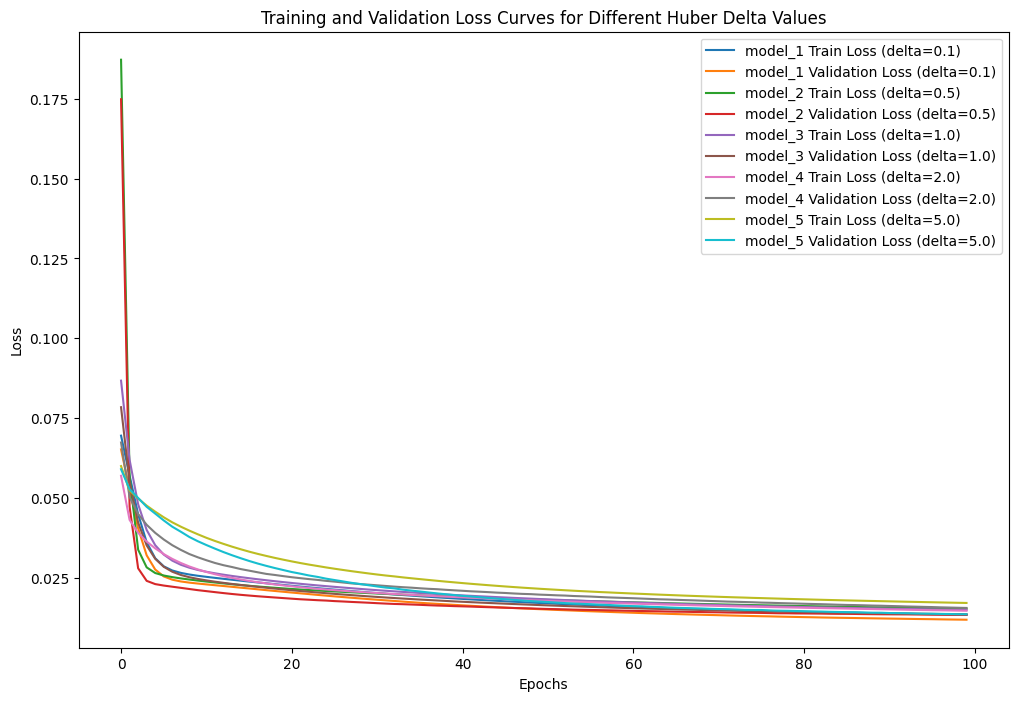

In [41]:
plt.figure(figsize=(12, 8))
for name, history in histories.items():
    plt.plot(history['train_losses'], label=f'{name} Train Loss (delta={models[name].loss_fn.delta})')
    plt.plot(history['val_losses'], label=f'{name} Validation Loss (delta={models[name].loss_fn.delta})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for Different Huber Delta Values')
plt.legend()
plt.show()

# Calculating R2 score for all models on validation set

In [42]:
# Calculate and print R2 scores on the validation set
r2_scores = {}
for name, model in models.items():
    r2 = model.R2_score(X_val.values, y_val.values.reshape(-1, 1))
    r2_scores[name] = r2
    print(f"{name} R^2 Score on Validation Set (delta={model.loss_fn.delta}): {r2:.4f}")

model_1 R^2 Score on Validation Set (delta=0.1): 0.0531
model_2 R^2 Score on Validation Set (delta=0.5): 0.4459
model_3 R^2 Score on Validation Set (delta=1.0): 0.4383
model_4 R^2 Score on Validation Set (delta=2.0): 0.3559
model_5 R^2 Score on Validation Set (delta=5.0): 0.4382


In [43]:
# Best model based on R2 score and its performance on the test set
best_model_name = max(r2_scores, key=r2_scores.get)
best_model = models[best_model_name]
preds = best_model.predict(X_test.values)
test_r2 = best_model.R2_score(X_test.values, y_test.values.reshape(-1, 1))
print(f"Best Model: {best_model_name} with R^2 Score on Test Set: {test_r2:.4f}")

Best Model: model_2 with R^2 Score on Test Set: 0.3611


Text(0, 0.5, 'Predicted Values')

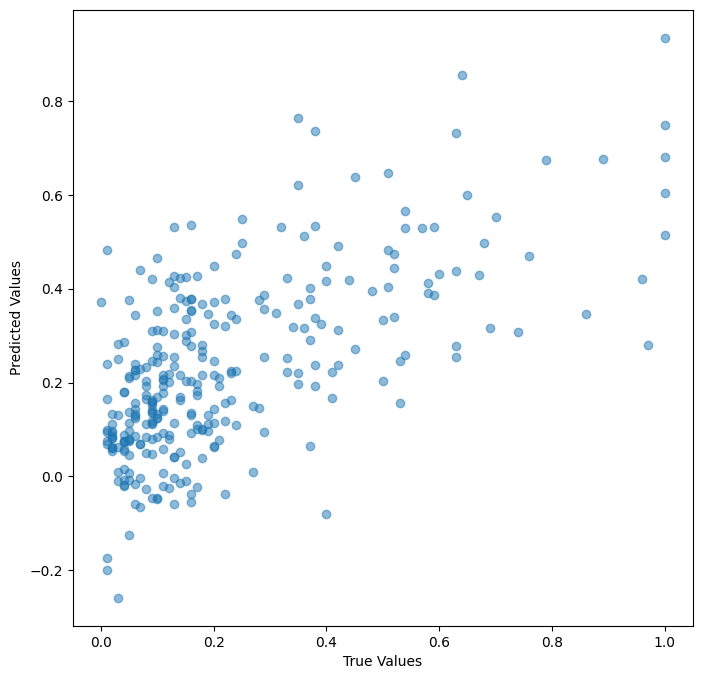

In [47]:
# Plot prediction of best model vs true values in a scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, preds, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')